![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Regressão periódica

## Dados

Nesta primeira parte iremos ajustar uma curva aos dados de demanda elétrica fornecidos pelo ONS,
para o período entre os dias *16.04.2018 - 16.05.2018*.

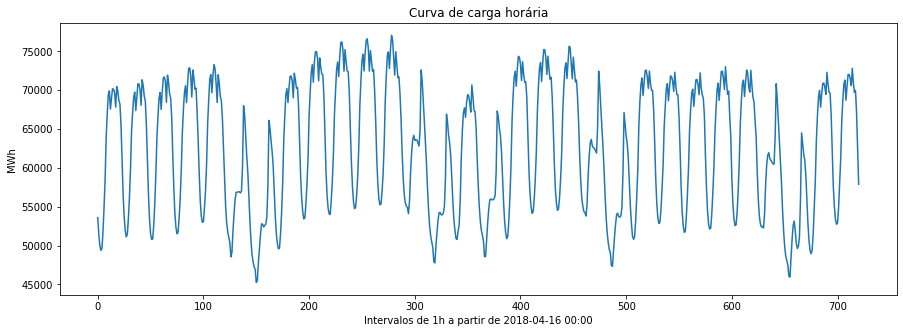

In [43]:
cch = np.load('Demanda_16.04.2018-16.05.2018.npz')
ys = cch['Demanda']
ts = np.arange(len(ys))

plt.figure(figsize=(15,5))
plt.plot(ts,ys)
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

Vamos pegar um intervalo com dias úteis.

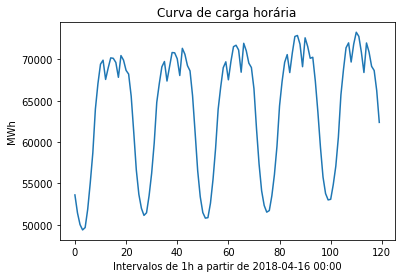

In [44]:
tmax = 120

plt.plot(ts[:tmax],ys[:tmax])
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

# Parte 1: Ajuste simples

## Questão 1: Matriz da regressão

O que salta aos olhos é o comportamento aproximadamente periódico,
logo uma primeira idéia é ajustar um modelo com funções também periódicas.

Um ajuste simples é o seguinte:
$$y(t) = c_0 + c_1\sin\left(\frac{2\pi t}{24}\right) + c_2\cos\left(\frac{2\pi t}{24}\right)$$

Explique porque o denominador 24 faz sentido para estes dados que temos.

Podemos pensar nisso utilizando física. Nessa disciplina, quando estudamos ondas, aprendemos que o coeficiente que acompanha $t$ (tempo) no argumento do seno é a frequência angular $w$. Essa frequência é definida como  $w = 2 \pi f$, sendo $f$ a frequência da nossa onda que, por sua vez, é escrita como $f = \frac{1}{T}$, sendo $T$ é o período da nossa função de onda. 

Assim, na função descrita acima, temos que:

$$
\frac{2 \pi}{24} = \frac{2 \pi}{T}\\ 
$$

Ou seja, $T = 24$. Faz bastante sentido o período dessa função periódica ser 24, tanto pelo que observamos do gráfico quanto pelo contexto. Intutivamente, é esperado que um certo padrão de demanda seja repetido a cada 24 horas. Analisando os gráficos acima, isso realmente parece acontecer.

Escreva a função `make_trig_matrix(ts,p)`, que monta a matriz de regressão $X$ tal que $Xc = y$ para o modelo proposto acima para `ts` e com período `p`.

**Observações:**
- A função constante está na base;
- A ordem das colunas importa para os asserts (mas não para o ajuste, se você sabe o que faz).
  Assim, as colunas devem vir na ordem das funções: constante, seno, cosseno.

In [45]:
def make_trig_matrix(ts,p):
    """ Retorna a matriz de regressão para o modelo y(t) = c0 + c1*sin(2*pi*t/p) + c2*cos(2*pi*t/p). """
    X = np.array([[1, np.sin((2*np.pi*t)/p), np.cos((2*np.pi*t)/p)] for t in ts])
    return X
       

In [46]:
tss = np.linspace(-2*np.pi,2*np.pi,51)
X = make_trig_matrix(tss,np.pi)

assert all([np.isclose(X[i][0],1) for i in range(10)])

In [47]:
# Testes de periodicidade

assert np.allclose(X[0][1],X[-1][1])
assert np.allclose(X[0][1],X[len(tss)//2][1])
assert np.allclose(X[0][2],X[-1][2])
assert np.allclose(X[0][2],X[len(tss)//2][2])

## Questão 2: Gráficos

Faça o gráfico tanto dos dados como do ajuste do modelo,
usando apenas as 120 primeiras observações, que correspondem aos primeiros cinco dias úteis.

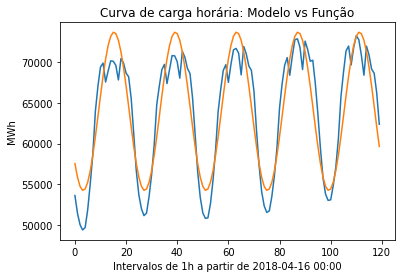

In [48]:
tmax = 120
X = make_trig_matrix(ts[:tmax], 24)
cs = np.linalg.lstsq(X , ys[:tmax], rcond=None)[0]
plt.plot(ts[:tmax],ys[:tmax], label="real function")
plt.plot(ts[:tmax],X@cs, label="model")
# plt.plot(ts[:tmax],ys[:tmax], label="model)
plt.title("Curva de carga horária: Modelo vs Função")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");
ax = plt.gca()
plt.show()

In [49]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

yss = [ax.lines[i].get_ydata() for i in range(2)]

assert 73000 <= np.max(yss) <= 73800
assert 49000 <= np.min(yss) <= 50000

In [50]:
ax = None

Plote também o residual (erro de ajuste)!

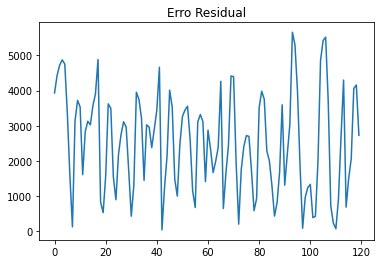

In [51]:
plt.plot(ts[:tmax],abs(ys[:tmax] - X@cs), label="model")
plt.title("Erro Residual")
ax = plt.gca()
plt.show()

In [52]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [53]:
ax = None

Esse gráfico reflete alguma tendência nos dados que difere do ajuste?
Se sim qual função poderia ser acrescentada a base do modelo para tentar capturar essa tendência?

Sim, diferentemente do ajuste o gráfico da função não é periódico ao longo de uma reta horizontal, ou seja, as ondas da função estão levente inclinadas, pois a tendência é de aumento da demanda ao longo da semana, respeitando as oscilações diárias. Podemos acrescentar uma função linear $f(x) = x$ na base do modelo para que essa tendência seja capturada. Essa análise é válida para os 5 primeiros dias, observando um gráfico como um todo, talvez fosse mais vantajoso adicionar um polinômio a base.

O que mais você percebe no gráfico de erros?

O erro é maior na região próxima das cristas e próxima dos vales da função real e é menor no meio da função.

## Questão 3: Uma base maior

Agora, vamos tentar um ajuste com mais funções (também ditas _harmônicos_):
$$y(t) = \alpha_0 +  \sum_{i=1}^k\alpha_i \sin\left(\frac{2\pi it}{24}\right) + \sum_{i=1}^k\beta_i \cos\left(\frac{2\pi it}{24}\right).$$

Para te auxiliar nessa tarefa escreva a função
- `make_full_trig_matrix(ts,p,i_max)`: Semelhante a `make_trig_matrix`, mas retorna a matriz para o ajuste acima,
  correspondente ao conjunto de harmônicos de $i=1$ até $i = i_{\max}$.

In [54]:
def make_full_trig_matrix(ts,p ,i_max):
    xs = []
    for t in ts:
        x = [1]
        for i in range(1, i_max+1):
            x.append(np.sin((np.pi * 2 * i * t)/p))
        for i in range(1, i_max+1):
            x.append(np.cos((np.pi * 2 * i * t)/p))
        xs.append(x)
    return np.array(xs)
       

In [55]:
# Teste de sanidade
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 1)
Y = make_trig_matrix(tss, 24)

for i in range(5):
    for j in range(3):
        assert np.isclose(X[i][j],Y[i][j])

In [56]:
# Teste de dimensão
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 3)
assert np.shape(X) == (100,7)

## Questão 4: Gráficos de novo

Faça o gráfico do ajuste para $i_{\max} = 2$, novamente para os 5 primeiros dias úteis.

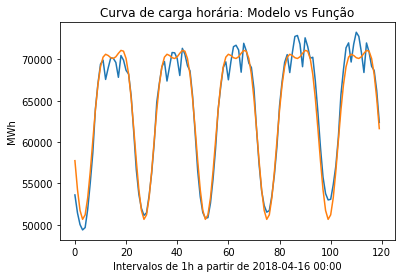

In [57]:
tmax = 120
X = make_full_trig_matrix(ts[:tmax], 24, 2)
cs = np.linalg.lstsq(X , ys[:tmax], rcond=None)[0]
plt.plot(ts[:tmax],ys[:tmax], label="real function")
plt.plot(ts[:tmax],X@cs, label="model")
# plt.plot(ts[:tmax],ys[:tmax], label="model)
plt.title("Curva de carga horária: Modelo vs Função")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00")
ax = plt.gca()
plt.show()

In [58]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

for i in range(2):
    yss = ax.lines[i].get_ydata()
    assert 71000 <= np.max(yss) <= 73300
    assert 49000 <= np.min(yss) <= 51300

In [59]:
ax = None

E não se esqueça do residual.

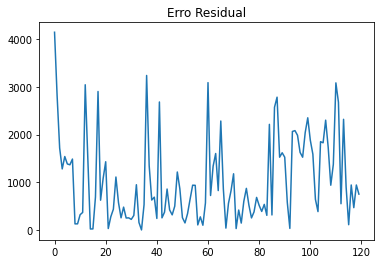

In [60]:
plt.plot(ts[:tmax],abs(ys[:tmax] - X@cs), label="model")
plt.title("Erro Residual")
ax = plt.gca()
plt.show()

In [61]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [62]:
ax = None

Agora, faça o gráfico do erro para $i_{\max} = 5$, $6$ e $10$, lado a lado.

**Dica:** Faça uma função `graph_err(imax, tmax)` que faz o gráfico do erro do ajuste em função de imax e tmax,
e use `subplot(n,m,k)` para selecionar o eixo.

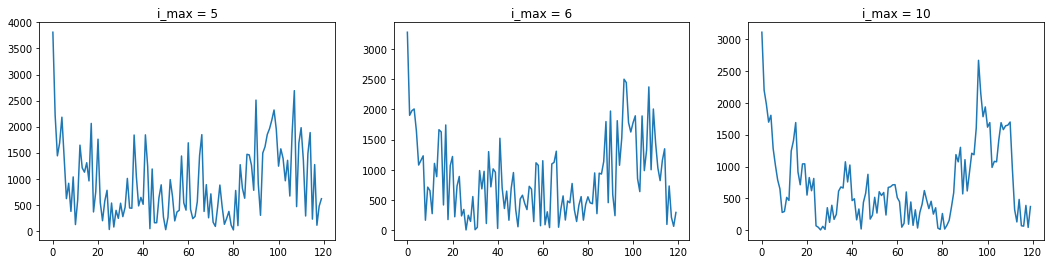

In [63]:
def graph_err(imax, tmax):
    X = make_full_trig_matrix(ts[:tmax], 24, imax)
    cs = np.linalg.lstsq(X , ys[:tmax], rcond=None)[0]
    return abs(ys[:tmax] - X@cs)

fig, axs = plt.subplots(ncols=3, figsize=(18,4))

axs[0].plot(ts[:tmax], graph_err(5, 120))
axs[0].set_title("i_max = 5")
axs[1].plot(ts[:tmax], graph_err(6, 120))
axs[1].set_title("i_max = 6")
axs[2].plot(ts[:tmax], graph_err(10, 120))
axs[2].set_title("i_max = 10")
plt.show()

O que você muda e o que não muda ao aumentar $i_{\max}$?

Com o aumento do $i_{max}$, podemos perceber que o erro diminui em alguns pontos, mas fica bem parecido em outros. Em geral, o gráfico de erros preserva o mesmo formato, mas com o aumento do $i_{max}$ podemos observar menos "oscilações", ou seja, o erro está de certa forma mais "comportado".

# Parte 2: Ajuste misto

## Questão 5: Polinômios e funções trigonométricas

Vamos adicionar polinômios à base, e comparar o erro de regressão obtido com uma base um pouco maior.

Comece implementando a função `make_poly_matrix(ts, d_max)`,
que retorna a matriz de ajuste polinomial de grau até $d_{\max}$.

Para não duplicar a coluna de 1's na matriz do modelo completo,
a função `make_poly_matrix` não retorna a coluna correspondente às funções constantes,
mas apenas aos polinômios $X$, $X^2$, ..., $X^{d_{\max}}$.

In [64]:
def make_poly_matrix(ts, dmax):
    assert dmax >= 1
    xs = []
    for t in ts:
        xs.append([t**d for d in range(1, dmax + 1)])
    return np.array(xs)

In [65]:
tss = np.arange(1,5)

X = make_poly_matrix(tss,3)

assert np.allclose(X[0],[1,1,1])
assert np.allclose(X[1],[2,4,8])
assert np.allclose(X[2],[3,9,27])
assert np.allclose(X[3],[4,16,64])

Agora, faça uma função que retorna a matriz do ajuste misto

In [66]:
def make_trig_poly(ts, p, imax, dmax):
    if dmax == 0:
        return make_full_trig_matrix(ts, p, imax)
    else:
        Xt = make_full_trig_matrix(ts, p, imax)
        Xp = make_poly_matrix(ts, dmax)
        Xm = []
        for i in range(0, len(Xt)):
            Xm.append(np.concatenate((Xt[i], Xp[i]), axis=0))
        return np.array(Xm)

## Questão 6: Mais gráficos ainda

Trace, num mesmo eixo, os erros correspondentes aos seguintes ajustes:
- Trigonométrico original, com apenas 1 harmônico
- Trigonométrico com 6 harmônicos
- Misto com 1 harmônico e um polinômio de grau 1
- Misto com 6 harmônicos e polinômio de grau 1
- Misto com 1 harmônico e polinômios de grau até 5
- Misto com 6 harmônicos e polinômios de grau até 5

In [67]:
def graph_err(ts, ys, p, imax, dmax):
    X = make_trig_poly(ts[:tmax], p, imax, dmax)
    cs = np.linalg.lstsq(X , ys[:tmax], rcond=None)[0]
    return abs(ys[:tmax] - X@cs)

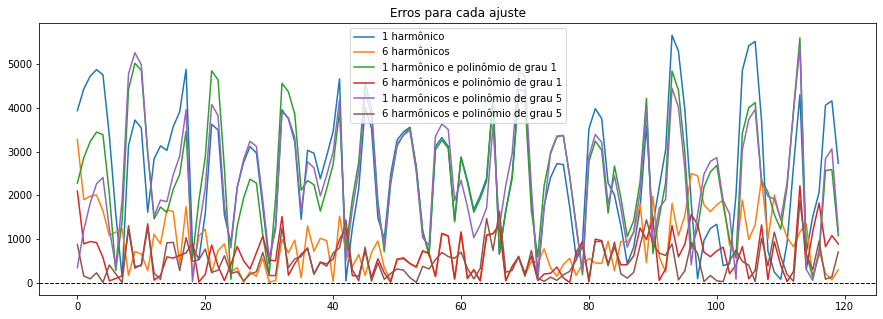

In [68]:
plt.figure(figsize=(15,5))

subts = ts[:120]
subys = ys[:120]

plt.plot(subts, graph_err(subts, subys, 24, 1, 0), label="1 harmônico")
plt.plot(graph_err(subts, subys, 24, 6, 0), label="6 harmônicos")

plt.plot(graph_err(subts, subys, 24, 1, 1), label="1 harmônico e polinômio de grau 1")

plt.plot(graph_err(subts, subys, 24, 6, 1), label="6 harmônicos e polinômio de grau 1")

plt.plot(graph_err(subts, subys, 24, 1, 5), label="1 harmônicos e polinômio de grau 5")

plt.plot(graph_err(subts, subys, 24, 6, 5), label="6 harmônicos e polinômio de grau 5")
plt.title("Erros para cada ajuste")

plt.legend()
plt.axhline(color='black', linestyle='--', linewidth=1)
ax = plt.gca()
plt.show()

In [69]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 7
assert len(ax.legend().texts) == 6

O que você observou? Que melhora é obtida com o acréscimo dos polinômios da base?

Novamente, o gráfico de erros apresenta muitos ruídos, mas de forma geral podemos observar uma redução grande no erro com o aumento da quantidade de harmônicos. A priori, o acréscimo dos polinômios não parece ter feito uma diferença significativa para a redução do erro.

Faça agora dois gráficos de erro, para separar em dois grupos.

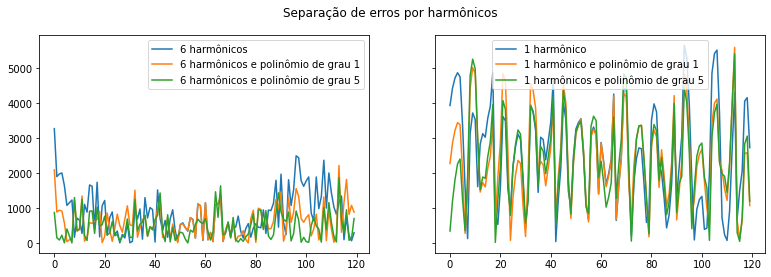

In [70]:
fig, axs = plt.subplots(ncols=2, figsize=(13,4), sharey=True)

subts = ts[:120]
subys = ys[:120]


axs[1].plot(subts, graph_err(subts, subys, 24, 1, 0), label="1 harmônico")
axs[0].plot(graph_err(subts, subys, 24, 6, 0), label="6 harmônicos")

axs[1].plot(graph_err(subts, subys, 24, 1, 1), label="1 harmônico e polinômio de grau 1")

axs[0].plot(graph_err(subts, subys, 24, 6, 1), label="6 harmônicos e polinômio de grau 1")

axs[1].plot(graph_err(subts, subys, 24, 1, 5), label="1 harmônicos e polinômio de grau 5")

axs[0].plot(graph_err(subts, subys, 24, 6, 5), label="6 harmônicos e polinômio de grau 5")
axs[0].legend()
axs[1].legend()
fig.suptitle('Separação de erros por harmônicos')
ax = plt.gca()
plt.show()

- Quais são os grupos que você escolheu?
- Porquê?

Os grupos foram separados de acordo com os harmônicos (1 ou 6). Podemos perceber que o erro com 6 harmônicos é muito menor que o erro com 1 harmônicos. Com esses gráficos fica mais claro que o acréscimo dos polinômios, apesar de reduzir levente o erro principalmente com o aumento do grau, faz pouca diferença. O maior impacto na redução do erro é causado pelo aumento dos harmônicos.

Essa escolha de separação é feita, justamente, para demontrar essa observação descrita acima que, de certa forma, justifica a questão anterior.